# GD_Newton_BFGS

## This script does the following

* Constructs the hybrid-NL
* Constructs different initial conditions for the iterative solvers (1) Gradient Descent, (2) Newton's method and (3) BFGS Algorithm
* Solves the non-linear equation as in (3.18) for different initial conditions for the iterative solvers
* Shows the results of the latter

# Import libraries and load functions

In [1]:
%run functions.ipynb

# Offline stage

# Create FOM snapshots

In [2]:
# Choose number of snapshots and test samples
ntest = 100
nsamples = 500 + ntest

# Choose LL-coupled problem 1 or thermal block

alreadyrun = 1

if not alreadyrun:
    %run FOM_snapshots.ipynb

    # Open a file and use dump()
    variables = [S, S1, SI, S2, A_I1_array, A_1I_array, A_11_array, A_II1_array, F_1_array, mu,  F_1_array, F_1I_array, snapshots_time, m3_time_train]

    with open('offline_vars.pkl', 'wb') as file:

        # create new file
        pickle.dump(variables, file)
else:   
    with open('offline_vars.pkl', 'rb') as file:

        # Call load method
        S, S1, SI, S2, A_I1_array, A_1I_array, A_11_array, A_II1_array, F_1_array, mu,  F_1_array, F_1I_array, snapshots_time, m3_time_train = pickle.load(file)

# Perform POD analysis

Snapshot energy domain 1: 0.9666179772016339
Snapshot energy domain 2: 0.9901551696750418
Snapshot energy interface: 0.9819837091583478


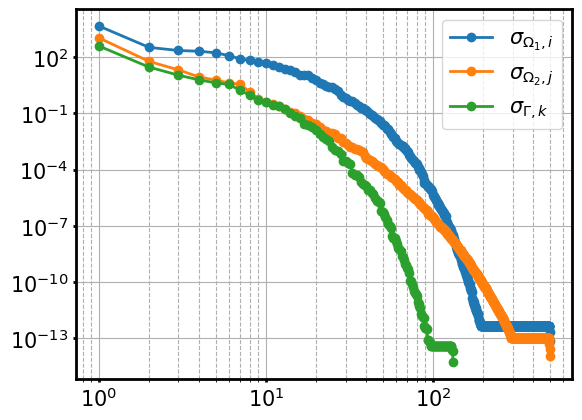

In [3]:
# Choose number of modes in reduced-order spaces
cutoff1 = 10
cutoffI = 5
cutoff2 = 5

V_1, V_I, V_2, ndofs_u1, ndofs_uI, ndofs_u2, u1, uI, u2 = POD_all(S1, SI, S2, cutoff1, cutoffI, cutoff2)

# Generate $\tilde{\mathcal{T}}_{n_s}$ and $\{ t_\Gamma(\mu^i)  \}_{i=1}^{n_s}$

In [4]:
a_1I_array = np.zeros((nsamples,ndofs_u1,ndofs_uI))
a_11_array = np.zeros((nsamples,ndofs_u1,ndofs_u1))
f_1_array = np.zeros((nsamples,ndofs_u1))

a_I1_array = np.zeros((nsamples,ndofs_uI, ndofs_u1))
a_II1_array = np.zeros((nsamples,ndofs_uI, ndofs_uI))
f_1I_array = np.zeros((nsamples,ndofs_uI))

traction_array34 = np.zeros((nsamples,ndofs_uI))
a1_tilde_array = np.zeros((nsamples,ndofs_uI,ndofs_uI))
f1_tilde_array = np.zeros((nsamples,ndofs_uI))

# Compute some precomputations

sV_1 = sps.csc_matrix(V_1)
sV_1T = sps.csc_matrix(V_1.T)

sV_I = sps.csc_matrix(V_I)
sV_IT = sps.csc_matrix(V_I.T)

for i in range(nsamples):
    print(i+1, "precomputations done,",nsamples-i-1,"to go...", end="\r")

    a_1I = sV_1T*A_1I_array[i]*sV_I
    a_11 = sV_1T*A_11_array[i]*sV_1
    f_1 = sV_1T*F_1_array[i]

    a_1I_array[i] = a_1I.toarray()
    f_1_array[i] = f_1
    a_11_array[i] = a_11.toarray()
    
    # ---- computation of traction force for the hybrid-NL ----
    
    a_I1 = sV_IT*A_I1_array[i]*sV_1
    a_II1 = sV_IT*A_II1_array[i]*sV_I 
    f_1I = sV_IT*F_1I_array[i]
    
    a_I1_array[i] = a_I1.toarray()
    a_II1_array[i] = a_II1.toarray()
    f_1I_array[i] = f_1I
    
    a1_tilde = a_II1-a_I1*sps.linalg.inv(a_11)*a_1I
    f1_tilde = a_I1*sps.linalg.inv(a_11)*f_1-f_1I
    traction = a1_tilde*uI[i]+f1_tilde
    
    traction_array34[i] = traction
    a1_tilde_array[i] = a1_tilde.toarray()
    f1_tilde_array[i] = f1_tilde    

# Train separate neural networks $\hat{\pi}^{(i)}_2$ for $i=1,2,...,n_2$

In [5]:
alreadyrun = 1

if not alreadyrun:
    start = time.time()
    
    nmodes = 1
    n_epochs = 1000
    
    learning_rate = 0.1
    torch_inputs = torch.from_numpy(np.column_stack((uI[0:nsamples-ntest], mu[0:nsamples-ntest,4]))).float()
    u_2_models34 = []

    for i in range(int(cutoff2/nmodes)):
        if i == 1:
            learning_rate = 0.01
            
        if i == 6:
            n_epochs = 500

        torch_outputs = torch.from_numpy(u2[0:nsamples-ntest,i*nmodes:i*nmodes+nmodes]).float()
        print("Training a Neural Network for mode",i*nmodes+1,"on domain 2...")
        u_2_model, NN2time, loss = Neural_Network_small(torch_inputs, torch_outputs, n_epochs, learning_rate)

        u_2_models34.append(u_2_model)
    end = time.time()
    time_u2_34 = end-start
    
    # Open a file and use dump()
    variables = [u_2_models34, time_u2_34]

    with open('u_2_models34.pkl', 'wb') as file:

        # create new file
        pickle.dump(variables, file)
else:   
    with open('u_2_models34.pkl', 'rb') as file:

        # Call load method
        u_2_models34, time_u2_34 = pickle.load(file)

# Train neural network $\hat{t}_\Gamma$

In [6]:
alreadyrun = 1

if not alreadyrun:

    traction_output = (traction_array34[:nsamples-ntest])

    # Train NN for traction force
    torch_inputs = torch.from_numpy(np.column_stack((uI[0:nsamples-ntest], mu[0:nsamples-ntest,4]))).float()

    traction_torch_outputs = torch.from_numpy(traction_output).float()

    n_epochs = 1000 
    learning_rate = 0.0005

    print("Trianing a Neural Network for the traction force...")
    traction_model34, traction_time34, loss = Neural_Network(torch_inputs, traction_torch_outputs, n_epochs, learning_rate)
    
    # Open a file and use dump()
    variables = [traction_model34, traction_time34]

    with open('traction_model34.pkl', 'wb') as file:

        # create new file
        pickle.dump(variables, file)
else:   
    with open('traction_model34.pkl', 'rb') as file:

        # Call load method
        traction_model34, traction_time34 = pickle.load(file)

# Construct bad initial conditions

In [7]:
minvals = np.zeros((ndofs_uI))
maxvals = np.zeros((ndofs_uI))
avgvals = np.zeros((ndofs_uI))

for index in range(ndofs_uI):
    maxval = max(uI[:,index])
    minval = min(uI[:,index])
    
    avgval = (maxval+minval)/2
    
    minvals[index] = minval
    maxvals[index] = maxval
    avgvals[index] = avgval

print(minvals)
print(maxvals)
print(avgvals)

[-21.00072793  -7.12578154  -1.83884071  -1.04241164  -0.83355045]
[-10.15973867   2.0980708    2.05811827   1.30481452   0.77133467]
[-15.5802333   -2.51385537   0.10963878   0.13120144  -0.03110789]


# Gradient Descent

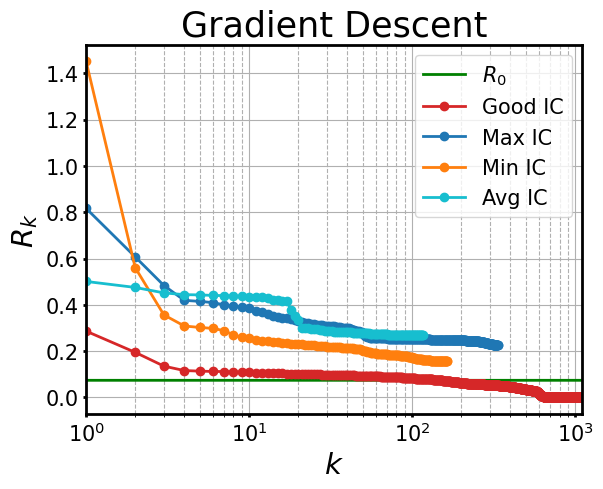

[0.01627121 0.4754658  0.22517052 0.26552055]
[0.27999906 0.14159633 0.55800012 0.54917049 0.92614944 0.95063327
 0.74845215 0.22926468 0.40863118]


In [8]:
# Choose test sample between 0 and ntest
j = 1

# Initialize
h = 1e-5
threshold = 1e-7
gamma = 1e-1

nmodes = 1
 
which = nsamples-ntest+j
mu_test = mu[which]
uI_exact = uI[which]

# Determine the reduced vector on the interface 
initial, norm, mu_start = find_initial_condition(mu, mu_test, uI, nsamples, ntest)

initials = [initial, minvals, maxvals, avgvals]
u_I_preds = []

counts = []
residuals_list = []
rel_errors = np.zeros((len(initials)))

for idx, initial in enumerate(initials):
    
    u_I_pred, delta_norm, fk, count, residuals = newdescent(initial, mu_test[4], h, gamma, a1_tilde_array[which], f1_tilde_array[which], threshold, traction_model34)
    rel_error = relative_error(uI_exact,u_I_pred)
    rel_errors[idx] = rel_error
    
    u_I_preds.append(u_I_pred)
    counts.append(count)
    residuals_list.append(residuals)
    

# Plot the gradient descent graph of the initial conditions
F_k_exact = traction_array34[which] - input_to_output_model_nonorm(uI_exact,mu_test[4],traction_model34)
R0 = np.linalg.norm(F_k_exact)

X = np.arange(1,max(counts)+1)
z = R0*np.ones(max(counts))

plt.plot(X, z, color='g', label='$R_0$', linewidth=2)
colors = ['tab:red', 'tab:blue', 'tab:orange', 'tab:cyan']
legend = ['$R_0$','Good IC','Max IC','Min IC', 'Avg IC']

counter = 0
for residuals in residuals_list:
    x = np.arange(1,counts[counter]+1)
    
    plt.plot(x,residuals, marker = 'o', color = colors[counter], label = legend[counter+1], linewidth=2)
    counter += 1
    
plt.xlabel("$k$")
plt.ylabel("$R_k$")
plt.xlim([1, max(counts)+1])

plt.title("Gradient Descent")
plt.legend()

plt.grid(True, which='major', linestyle='-')
plt.grid(True, which='minor', linestyle='--')
plt.xscale('log')

plt.savefig('comparison_gd_4', bbox_inches='tight')
plt.show()

print(rel_errors)
print(mu_test)
    

# BFGS

/tmp/ipykernel_569/1154073383.py:1334: RuntimeWarning: divide by zero encountered in double_scalars
  rho_k = 1/np.dot(y_k.T,s_k)


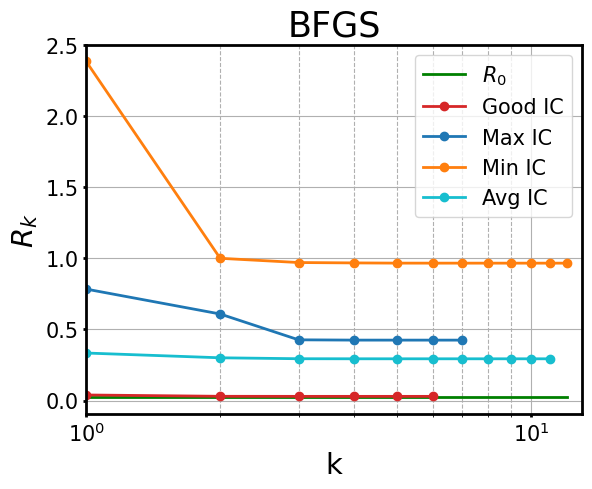

[0.02018033 0.39745802 0.43169583 0.25754801]
[0.62049456 0.69741538 0.76925861 0.16400002 0.69394057 0.52837846
 0.35976505 0.5409995  0.76151837]


In [9]:
# Choose test sample between 0 and ntest
j = 4

# Define input parameters for BFGS algorithm
x_k = initial
H_k = np.identity(len(x_k),float)

h = 1e-5
threshold = 1e-7
    
start = time.time()
which = nsamples-ntest+j

mu_test = mu[which]
uI_exact = uI[which]

# Determine the reduced vector on the interface
initial, norm, mu_start = find_initial_condition(mu, mu_test, uI, nsamples, ntest)

initials = [initial, minvals, maxvals, avgvals]
u_I_preds = []

counts = []
residuals_list = []
rel_errors = np.zeros((len(initials)))

for idx, initial in enumerate(initials):
    
    u_I_pred, residuals, count = BFGS(initial, H_k, threshold, h, mu_test[4], a1_tilde_array[which], f1_tilde_array[which], traction_model34)
    rel_error = relative_error(uI_exact,u_I_pred)
    rel_errors[idx] = rel_error
    
    u_I_preds.append(u_I_pred)
    counts.append(count)
    residuals_list.append(residuals)
    
# Plot the gradient descent graph of the initial conditions
F_k_exact = traction_array34[which] - input_to_output_model_nonorm(uI_exact,mu_test[4],traction_model34)
R0 = np.linalg.norm(F_k_exact)

X = np.arange(1,max(counts)+1)
z = R0*np.ones(max(counts))

plt.plot(X, z, color='g', label='$R_0$', linewidth=2)
colors = ['tab:red', 'tab:blue', 'tab:orange', 'tab:cyan']
legend = ['$R_0$','Good IC','Max IC','Min IC', 'Avg IC']

counter = 0
for residuals in residuals_list:
    x = np.arange(1,counts[counter]+1)
    
    plt.plot(x,residuals, marker = 'o', color = colors[counter], label = legend[counter+1], linewidth=2)
    counter += 1
    
plt.xlabel("k")
plt.ylabel("$R_k$")
plt.xlim([1, max(counts)+1])

plt.title("BFGS")
plt.legend()

plt.grid(True, which='major', linestyle='-')
plt.grid(True, which='minor', linestyle='--')
plt.xscale('log')

plt.savefig('comparison_bfgs_1', bbox_inches='tight')
plt.show()

print(rel_errors)
print(mu_test)

# Newton's Method

No convergence


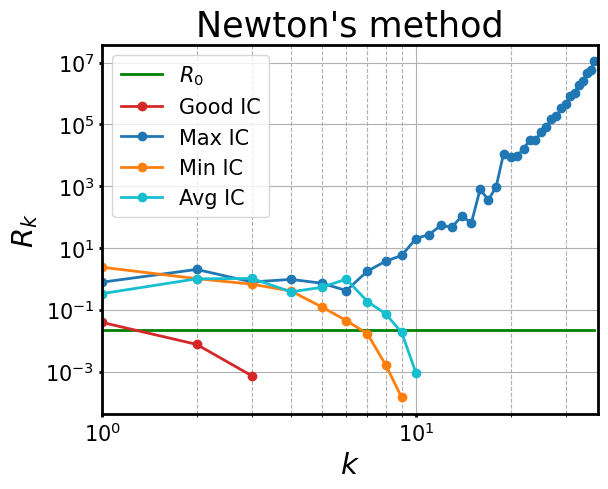

[1.04463794e-02 3.38220422e+06 1.04163473e-02 1.04252583e-02]
[0.62049456 0.69741538 0.76925861 0.16400002 0.69394057 0.52837846
 0.35976505 0.5409995  0.76151837]


In [10]:
# Choose test sample between 0 and ntest
j = 4

criterion = 0
threshold = 1e-3
 
start = time.time()
which = nsamples-ntest+j

mu_test = mu[which]
uI_exact = uI[which]

# Determine the reduced vector on the interface
initial, norm, mu_start = find_initial_condition(mu, mu_test, uI, nsamples, ntest)

initials = [initial, minvals, maxvals, avgvals]
u_I_preds = []

counts = []
residuals_list = []
rel_errors = np.zeros((len(initials)))

for idx, initial in enumerate(initials):
    u_I_pred, delta_norm, fk, count, residuals = newton_nonorm(initial, mu_test[4], h, a1_tilde_array[which], f1_tilde_array[which], criterion, threshold, traction_model34)

    rel_error = relative_error(uI_exact,u_I_pred)
    rel_errors[idx] = rel_error
    
    u_I_preds.append(u_I_pred)
    counts.append(count)
    residuals_list.append(residuals)

# Plot the gradient descent graph of the initial conditions
F_k_exact = traction_array34[which] - input_to_output_model_nonorm(uI_exact,mu_test[4],traction_model34)
R0 = np.linalg.norm(F_k_exact)

X = np.arange(1,max(counts)+1)
z = R0*np.ones(max(counts))
plt.figure(figsize=(6.4, 4.8))

plt.plot(X, z, color='g', label='$R_0$', linewidth=2)
colors = ['tab:red', 'tab:blue', 'tab:orange', 'tab:cyan']
legend = ['$R_0$','Good IC','Max IC','Min IC', 'Avg IC']

counter = 0
for residuals in residuals_list:
    x = np.arange(1,len(residuals)+1)
    
    plt.plot(x,residuals, marker='o', color = colors[counter], label = legend[counter+1], linewidth=2)
    counter += 1
    
plt.xlabel("$k$")
plt.ylabel("$R_k$")

plt.title("Newton's method")
plt.legend()
plt.xlim([1, max(counts)+1])

plt.grid(True, which='major', linestyle='-')
plt.grid(True, which='minor', linestyle='--')
plt.xscale('log')

plt.yscale('log')
plt.savefig('comparison_newton_4', bbox_inches='tight')
plt.show()

print(rel_errors)
print(mu_test)